In [429]:
import json

In [430]:
file_path = 'Champion Data/'

def json_file_to_dict(file_name):
    try:
        # Open the file for reading
        with open(file_name, 'r') as file:
            # Read and convert the JSON data into a Python dictionary
            data = json.load(file)
            return data
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [431]:
reverse_team = {
    'enemy_top': 'team_top',
    'enemy_jungle': 'team_jungle',
    'enemy_middle': 'team_middle',
    'enemy_bottom': 'team_bottom',
    'enemy_support': 'team_support',
    'team_top': 'enemy_top',
    'team_jungle': 'enemy_jungle',
    'team_middle': 'enemy_middle',
    'team_bottom': 'enemy_bottom',
    'team_support': 'enemy_support'
}

winrate = {
    'enemy_top': {},
    'enemy_jungle': {},
    'enemy_middle': {},
    'enemy_bottom': {},
    'enemy_support': {},
    'team_top': {},
    'team_jungle': {},
    'team_middle': {},
    'team_bottom': {},
    'team_support': {}
}

cutoff = 333 # 1/.003

def aggregate_winrate(role, name):
    champion_json = json_file_to_dict(f'{file_path}{name}.json')
    if not champion_json:
        print(f'Could not find {file_path}{name}.json')
    games_played = champion_json['header']['n']
    match role:
        case 'enemy':
            # Get stats for each role
            for enemy_role in ['enemy_top', 'enemy_jungle', 'enemy_middle', 'enemy_bottom', 'enemy_support']:
                team_role = reverse_team[enemy_role]
                # Aggregate team winrates for each role's possible champions
                for team_name, team_stats in champion_json[enemy_role].items():
                    if team_stats['n'] * cutoff < games_played: break
                    winrate[team_role][team_name] = winrate[team_role].get(team_name, []) + [(team_stats['w'], team_stats['n'])]
                # Aggregate enemy winrates for each role's possible champions
                for enemy_name, enemy_stats in champion_json.get(team_role, {}).items():
                    if enemy_stats['n'] * cutoff < games_played: break
                    winrate[enemy_role][enemy_name] = winrate[enemy_role].get(enemy_name, []) + [(enemy_stats['w'], enemy_stats['n'])]

        case 'team':
            for team_role in ['team_top', 'team_jungle', 'team_middle', 'team_bottom', 'team_support']:
                enemy_role = reverse_team[team_role]
                # Aggregate team winrates for each role's possible champions
                for team_name, team_stats in champion_json.get(team_role, {}).items():
                    if team_stats['n'] * cutoff < games_played: break
                    winrate[team_role][team_name] = winrate[team_role].get(team_name, []) + [(team_stats['w'], team_stats['n'])]
                # Aggregate enemy winrates for each role's possible champions
                for enemy_name, enemy_stats in champion_json[enemy_role].items():
                    if enemy_stats['n'] * cutoff < games_played: break
                    winrate[enemy_role][enemy_name] = winrate[enemy_role].get(enemy_name, []) + [(enemy_stats['w'], enemy_stats['n'])]

        case _:
            print(f'Unknown role \'{role}\' for {name}')
            return False
    print(f'Aggregated {role} {name}')
    return True

winrate_sorted = {
    'enemy_top': [],
    'enemy_jungle': [],
    'enemy_middle': [],
    'enemy_bottom': [],
    'enemy_support': [],
    'team_top': [],
    'team_jungle': [],
    'team_middle': [],
    'team_bottom': [],
    'team_support': []
}

rounding = 2

def sorted_champion_picks():
    for role, role_champs in winrate.items():
        for champ_name, wn_list in role_champs.items():
            sum_w = sum(t[0] for t in wn_list)
            sum_n = sum(t[1] for t in wn_list)
            wr = round(100*sum_w / sum_n, rounding)
            winrate_sorted[role].append((wr, champ_name))

        winrate_sorted[role] = sorted(winrate_sorted[role], reverse=True)
    

In [432]:
enemy_team = ['darius', 'ahri', 'leesin', 'ezreal', 'maokai']
ally_team = ['aatrox', 'graves', 'jhin', 'senna']

for enemy_champ in enemy_team:
    aggregate_winrate('enemy', enemy_champ)

for ally_champ in ally_team:
    aggregate_winrate('team', ally_champ)
    
sorted_champion_picks()


Aggregated enemy darius
Aggregated enemy ahri
Aggregated enemy leesin
Aggregated enemy ezreal
Aggregated enemy maokai
Aggregated team aatrox
Aggregated team graves
Aggregated team jhin
Aggregated team senna


In [433]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.ticker as mtick

def visualize_overlapped_bell_curves(win_loss):
    plt.figure(figsize=(12, 2))
    plt.gca().set_yticklabels([])
    plt.yticks([])
    plt.box(False)
    plt.xticks(np.arange(0, 1, .1))
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))


    x = np.linspace(0.0, 1.0, 1000)
    cumulative_y = np.zeros_like(x)
    for i, (heads, tails) in enumerate(win_loss, start=1):
        n = heads + tails  # Total number of flips
        p_hat = heads / n  # Estimated probability of heads
        std_dev = np.sqrt(p_hat * (1 - p_hat) / n)  # Standard deviation
        # Calculate the PDF (Probability Density Function) values
        y = norm.pdf(x, p_hat, std_dev)
        # Accumulate the PDF
        cumulative_y += y
    plt.plot(x, cumulative_y, color="#505050")
    plt.show()

experiments = [
    (1301, 950),
    (19000, 18200),  
    (5100, 6072),
    (15200, 13415),
    (10210, 10833),
    (10210, 10813),
    (12210, 10833),
    (10250, 12833),
    (16210, 11833),
    (6000,6000)
]
#visualize_overlapped_bell_curves(experiments)

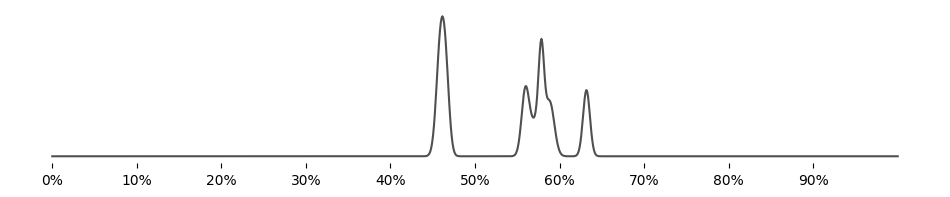

Smolder winrate: 54.21
Best pick for middle: [(54.44, 'Sion'), (54.4, 'Malphite'), (54.19, '45'), (54.17, 'Akali'), (54.01, 'Malzahar')]


In [435]:
def show_graph(champ_name):
    champion_json = json_file_to_dict(f'{file_path}{champ_name}.json')
    lane = champion_json['header']['defaultLane']
    role = f'team_{lane}'
    stats = winrate[role][champ_name]
    win_loss = []
    #print([round(100*t[0]/t[1], 2) for t in stats])
    for stat in stats:
        win_loss.append((stat[0], stat[1]-stat[0]))
    visualize_overlapped_bell_curves(win_loss)
    wr = next((t for t in winrate_sorted[role] if t[1] == champ_name), None)
    return wr[0]

def best_picks(lane):
    role = f'team_{lane}'
    stats = winrate_sorted[role]
    return stats[:5]


pick = 'Smolder'
#print(json.dumps(winrate_sorted, indent=4))
wr = show_graph(pick)
print(f'{pick} winrate: {wr}')

lane = 'middle'
best = best_picks(lane)
print(f'Best pick for {lane}: {best}')

